In [18]:
Bearbeitungs_Zeit = '09:00 - 12:00' #@param {type:"string"}

In [19]:
Datum = '2022-03-29' #@param {type:"date"}

## Bitte, keine Umlaute verwenden!

In [20]:
Name = 'Loeffel' #@param {type:"string"}
Vorname = 'Benjamin' #@param {type:"string"}

# Deeplearning - Dense Networks (MLP) und MLP Autoencoders

## 1. Aufgabe - Dense Network - Classification 

Das u.a. Netzwerk soll schwarz-weisse Bilder klassifizieren. Es gibt insgesamt 10 Bild-Klassen.

In [21]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

# Download training data from open datasets.
# - ToTensor() erstelle proprietäres Format für Arrays welches PyTorch dann nutzt.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),    
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label.

**1.1. Frage**: Bei der Definition von self.linear_relu_stack sind **2 (zwei)** Fehler eingeschlichen. Korregieren Sie diese.

**1.2. Frage**: Bei der Erstellungs des Model-Objekts mit model = NeuralNetwork(...) wurde wieder **1 (ein) Fehler** gemacht. Finden Sie diesen Bug!

Dabei ist insbesondere zu beachten, dass 
1. Imagesize 28 x 28 ist. 
2. Die Prediction für 10 Kategorien erstellt wird

In [23]:

class NeuralNetwork(nn.Module):                       # 1. Klasse erstellen von nn.Module
    def __init__(self, input_size:int):               # 2. Konstruktor
        super().__init__()                            # Super Konstruktor aufrufen
        self.input_size = input_size                  # Input 28x28, Output = 512
                                                     
        self.linear_relu_stack = nn.Sequential(       # Einfache Netzwerk übereinander (Sequential)
            nn.Flatten(),
            nn.Linear(self.input_size, 128),          # FIX: veratuscht
            nn.ReLU(),
            nn.Linear(128, 10),                       # Prediction für 10 Kategorien
            nn.Softmax()                              # FIX Softmax
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

model = NeuralNetwork(input_size=28*28).to(device)   # Angabe wo das ausgeführt werden soll
                                                     # per default ist CPU
                                                     # FIX input_size
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=None)
  )
)


**1.3. Frage**: Hier hat man bei der Backpropagation die Reihenfolge von zwei aufeinander folgender Befehle vertauscht. Ein scheinbar kleiner Fehler würde dazu führen, dass das Model nicht trainiert wird, obwohl der Code evtl. ohne Fehler ausgeführt werden kann. Finden Sie diesen Fehler!

**1.4. Frage**: Im test hat man auch **einen Fehler** (eine fehlende Zeile). Dieser führt dazu, dass auch beim Testen Gradienten berechnet und akkumuliert werden, was dazu führen würde , dass die Ressourcen unnötig verschwendet würden. Ergänzen Sie bitte diese fehlende Zeile.

**1.5. Frage**: Trainieren und testen Sie das Model für 5 Epochen.

**1.6. Frage**: Was macht die Befehlszeile optimizer.step()? Bitte kurz in eigenen Worten beschreiben.

Um ein Neuronales Netz zu trainieren, müssen Gewichte und Biases aller Neuronen auf allen Layers optimiert werden. Dies geschieht durch Backpropagation der Losses. Wurde diese Backpropagation für den betreffenden Batch ausgeführt, werden nun nurch den optimizer.step() die Gewichte und Biases gemäss der implementierten Update-Stategie angepasst. Dabei werden die vorgängig berechneten Gradienten, die an den Tensoren mitgeführt werden, verwendet.





In [24]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # Compute prediction
    pred = model(X)
    # Compute prediction error
    loss = loss_fn(pred, y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()   # FIX loss.backward vor step
    optimizer.step()
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad(): # FIX with toch.no_grad()
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")   

batch_size = 64
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

epochs = 5 # FIX number of epochs
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
  print("Done!")



Epoch 1
-------------------------------
loss: 2.298356 [    0/60000]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 1.808315 [ 6400/60000]
loss: 1.713271 [12800/60000]
loss: 1.795413 [19200/60000]
loss: 1.729681 [25600/60000]
loss: 1.743111 [32000/60000]
loss: 1.643878 [38400/60000]
loss: 1.652118 [44800/60000]
loss: 1.706347 [51200/60000]
loss: 1.752447 [57600/60000]
Test Error: 
 Accuracy: 77.7%, Avg loss: 1.690879 

Done!
Epoch 2
-------------------------------
loss: 1.654753 [    0/60000]
loss: 1.664015 [ 6400/60000]
loss: 1.681251 [12800/60000]
loss: 1.725250 [19200/60000]
loss: 1.690197 [25600/60000]
loss: 1.723219 [32000/60000]
loss: 1.617329 [38400/60000]
loss: 1.659422 [44800/60000]
loss: 1.689031 [51200/60000]
loss: 1.736467 [57600/60000]
Test Error: 
 Accuracy: 76.5%, Avg loss: 1.697256 

Done!
Epoch 3
-------------------------------
loss: 1.639613 [    0/60000]
loss: 1.626902 [ 6400/60000]
loss: 1.655311 [12800/60000]
loss: 1.718137 [19200/60000]
loss: 1.675952 [25600/60000]
loss: 1.720094 [32000/60000]
loss: 1.588545 [38400/60000]
loss: 1.656221 [44800/60000]
loss: 1.695065 [51200

## 2. Aufgabe - Dense Autoencoder

**2.1. Frage**: Ändern Sie die Grösse des Bottleneck-Layers so, dass man den Output vom Encoder printen kann.

**2.2. Frage**: Trainieren Sie das Autoencoder-Model für 5 Epochen

**2.3. Frage**: Speichern Sie das Latent-Space des Autonecoders in einer Variable, indem Sie sämtliche Testdaten an den Encoder des Models übergeben. Verwenden Sie als Input die Property test_dataloader.dataset.data

Achten Sie darauf, die Inputdaten korrekt zu reshapen.

**2.4. Frage**: Plotten Sie das Latent-Space (scatter-plot) unter Verwendung vom matplotlib.pyplot Library. Achten Sie darauf, das Latent-Space vorher zu numpy zu konvertieren.

**2.5. Frage**: Für welche Aufgaben würden Sie einen Autoencoder verwenden. Nennen Sie mindestens zwei.

**2.6. Frage**: Was verstehen Sie unter "Latentspace"? Bitte kurz und bündig in eigenen Worten beschreiben.



Bitte hier die Antwort auf die Frage 2.5 eingeben


*   Anomaliedetektion
*   Entfernen von Rauschen/Fehlern auf Bildern



Bitte hier die Antwort auf die Frage 2.6 eingeben

Der Autoencoder ist architektonisch eine Kompression mit Anschliessender Dekompression der Daten. Folglich wird im Latentspace nach der Kompression eine komprimierte Sicht der Daten wiedergegeben. Es handelt sich dabei um Hyperstrukturen wie eine Art Kondensat. Durch die Grösse des Latentspace kann gesteuert werden, welche Komplexität nach der Kompression noch vorliegen soll, sprich welche Menge Entropie noch abgebildet werden kann.

Model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)


Epoch 0
-------------------------------
loss: 0.171649 [    0/60000]
loss: 0.061180 [ 6400/60000]
loss: 0.061483 [12800/60000]
loss: 0.040678 [19200/60000]
loss: 0.041964 [25600/60000]
loss: 0.038787 [32000/60000]
loss: 0.031988 [38400/60000]
loss: 0.033526 [44800/60000]
loss: 0.033845 [51200/60000]
loss: 0.032619 [57600/60000]


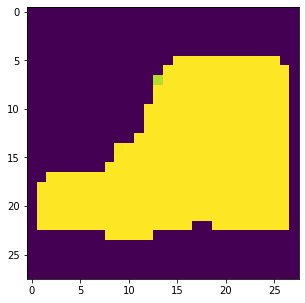

Epoch 1
-------------------------------
loss: 0.034273 [    0/60000]
loss: 0.031862 [ 6400/60000]
loss: 0.033981 [12800/60000]
loss: 0.032748 [19200/60000]
loss: 0.034896 [25600/60000]
loss: 0.034277 [32000/60000]
loss: 0.030783 [38400/60000]
loss: 0.030853 [44800/60000]
loss: 0.032904 [51200/60000]
loss: 0.030605 [57600/60000]


Epoch 2
-------------------------------
loss: 0.033600 [    0/60000]
loss: 0.029524 [ 6400/60000]
loss: 0.030720 [12800/60000]
loss: 0.032070 [19200/60000]
loss: 0.031577 [25600/60000]
loss: 0.032897 [32000/60000]
loss: 0.029782 [38400/60000]
loss: 0.029318 [44800/60000]
loss: 0.031632 [51200/60000]
loss: 0.029371 [57600/60000]


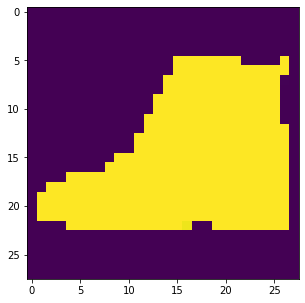

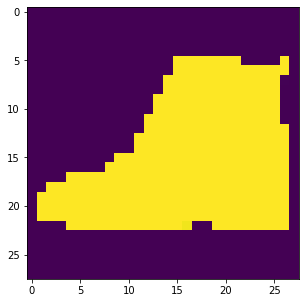

Epoch 3
-------------------------------
loss: 0.033297 [    0/60000]
loss: 0.028416 [ 6400/60000]
loss: 0.029329 [12800/60000]
loss: 0.030412 [19200/60000]
loss: 0.030189 [25600/60000]
loss: 0.032054 [32000/60000]
loss: 0.028413 [38400/60000]
loss: 0.028187 [44800/60000]
loss: 0.031791 [51200/60000]
loss: 0.028015 [57600/60000]


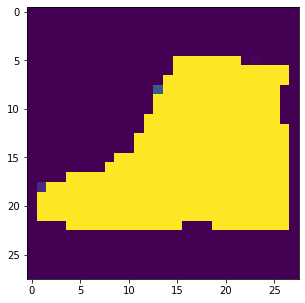

Epoch 4
-------------------------------
loss: 0.031671 [    0/60000]
loss: 0.027704 [ 6400/60000]
loss: 0.028268 [12800/60000]
loss: 0.028919 [19200/60000]
loss: 0.029046 [25600/60000]
loss: 0.030639 [32000/60000]
loss: 0.027580 [38400/60000]
loss: 0.027443 [44800/60000]
loss: 0.031132 [51200/60000]
loss: 0.027309 [57600/60000]


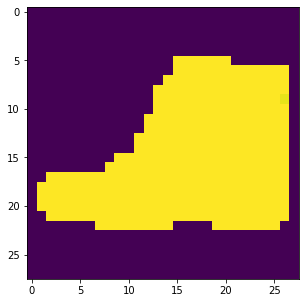

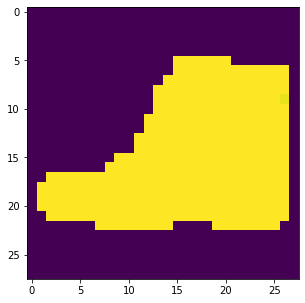

In [25]:

from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class Model(nn.Module):
  def __init__(self, n_features: int):
      super().__init__()
      self.n_features = n_features

      self.encoder = nn.Sequential(nn.Linear(n_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 16),
                                    nn.ReLU(),
                                    nn.Linear(16, 2), ) # FIX Latent Space Size = 2

      self.decoder = nn.Sequential(nn.Linear(2, 16),  # FIX Latent Space Size = 2
                                    nn.ReLU(),
                                    nn.Linear(16, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, self.n_features),
                                    nn.Sigmoid())

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x


model = Model(n_features=28 * 28).to(device)
print(model)


def printIMG(img):
  plt.figure(figsize=(10,5))
  plt.imshow(img)
  plt.show()

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  model.train()

  for batch, (X, y) in enumerate(dataloader):
      X = X.reshape(-1, 28 * 28)
      X = X.to(device)
      pred = model(X)
      loss = loss_fn(pred, X)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
  num_batches = len(dataloader)
  model.eval()
  test_loss = 0

  with torch.no_grad():
      for X, y in dataloader:
          X = X.reshape(-1, 28 * 28)
          X = X.to(device)

          pred = model(X)
          test_loss += loss_fn(pred, X).item()

      test_loss /= num_batches
      print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


def test_with_testimage(model, test_image, epoch: int, filename: str):
  model.eval()
  with torch.no_grad():
      test_image = test_image.reshape(-1, 28 * 28)
      test_image = test_image.to(device)
      predicted_test_image = model(test_image)
      predicted_test_image = predicted_test_image.reshape(-1, 28, 28)
      # print predicted_test_image[0]
      printIMG(predicted_test_image[0])


def save_weights(model: nn.Module, filename: str) -> None:
  torch.save(model.state_dict(), filename)


loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # step, update von params = params - lr * grad

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

test_image = test_data.data[0, :, :].float()
# print test_image
printIMG(test_image)

noise = torch.randn(test_image.shape) * 0.1
noisy_test_image = torch.add(test_image, noise)
# print noisy_test_image
printIMG(noisy_test_image)
epochs=5
for epoch in range(epochs): #FIX epochs
  print(f"Epoch {epoch}\n-------------------------------")
  train(dataloader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer)
  # test(dataloader=test_dataloader, model=model, loss_fn=loss_fn)
  test_with_testimage(model=model, test_image=test_image, epoch=epoch, filename="no_noise")
  test_with_testimage(model=model, test_image=noisy_test_image, epoch=epoch, filename="noise")
# Bottleneck anzahl encoder ändern -> (encounder output 2)
# Oder input encoder ändern etc

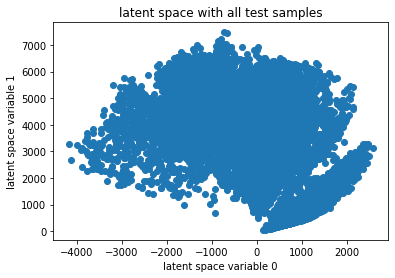

In [29]:
input_data=test_dataloader.dataset.data.reshape(-1,28*28).float()
input_data=input_data.to(device)
model.eval()
with torch.no_grad():
  encoder_output=model.encoder(input_data)

values = encoder_output.cpu().detach().numpy()
plt.scatter(values[:,0],values[:,1])
plt.xlabel("latent space variable 0")
plt.ylabel("latent space variable 1")
plt.title("latent space with all test samples")
plt.show()

# Deep Reinforcement Learning

## 3. Aufgabe - Verständnis Fragen

**3.1. Frage**: Beschreiben Sie das Verhältnis zwische DeepLearning (DL) und Deep Reinforcement Learning (DRL).

Deep Learning und Reinforcement Learning sind beides Algorithmen, die selbstständig lernen. Der Unterschied zwischen ihnen besteht darin, dass Deep Learning aus einem Trainingssatz lernt und dieses Lernen dann auf einen neuen Datensatz anwendet, während Reinforcement Learning dynamisch lernt, indem es Aktionen auf der Grundlage von kontinuierlichem Feedback anpasst, um eine Belohnung zu maximieren.

Deep Learning und Reinforcement Learning schließen sich nicht gegenseitig aus. Tatsächlich kann man Deep Learning in einem Reinforcement-Learning-System verwenden, was als Deep Reinforcement Learning bezeichnet wird. Sprich es können die üblichen Technologien aus Deep Learning verwerndet werden, um beispielsweise das Online- und das Taget-Model abzubilden.


**3.2. Frage**: Nennen Sie bitte die 3 (drei) möglichen Einsatzgebiete von DRL

*   Optimierungsalgorithmen
*   Selbstfahrende Autos
*   Natural Language Processing








**3.3. Frage**: Definieren Sie in eigenen Worten die drei Hauptrechen-Grössen von DRL:
1. State-Value

2. State-Action Value

3. Advantage Value

1. State-Value:
Wert in einem Unmittelbaren Zustand (Reward)

2. State-Action Value:
Wert eine Aktion in einem bestimmten Zustand auszuführen (Reward nach dieser Action)

3. Advantage Value:
Eine Art "Bonus" in einem bestimmten State eine Action auszuführen relativ gegenüber dem Vorteil der Grundmenge aller Actions, die in diesem State möglich sind.

**3.4. Frage**:  Setzen Sie bitte die in Frage 3.3 definierten Grössen in einer Formel in Beziehung

$Q_d(s,a_d)=V(s)+(A_d(s,a_d)-\frac{1}{n}* \sum_{a^{'}_{d}\in A_{d}}^{} A_d(s,a^{'}_{d})) $

Oder in Pseudo Mathematik:

"Q(State,Action) = Value(State) + (Advantage(State,Action) - Mittelwert aller Advantages(State,Action))"

**3.5. Frage**: Erklären Sie bitte in eigenen Worten, warum beim Training von DRL-Modellen die Epsilon-Greedy Methode zum Einsatz kommt.

Inspiriert durch biologisches Lernen erkundet der Agent zuerst mit Random-Actions, welche Rewards er für Actions aus den jeweiligen States erhält. Er gewinnt so eine Experience, oder anders gesagt der Agent füllt seine Erinnerungen auf mit Erlebnissen, was er getan hat und den dabei erhaltenen Reward. Wir der Agent mit der Zeit "reifer", soll ein Uebergang stattfinden von Random-Actions, zu Actions, die aus den Erinnerungen abgeleitet werden (Effektives Anwenden des Gelernten). Dies wird häufig mit einer Epsilon-Greedy Strategie getan, damit ein "sanfter" Übergang zwischen Random-Actions und Anwenden des gelernten gemacht werden kann (Es handelt sich um eine Decay Funktion).
Ein Random Sampling zu Beginn ist notwendig, da der Agent ansonsten zu wenig gut über den Gesamten State- und Action-Raum generalisieren kann und in "lokalen Mustern" gefangen werden kann.

**3.6. Frage**: Ist Q-Learning ein Model Based oder Model Free Verfahren?

Hinweis: Mit Model ist NICHT das Agent-Model gemeint!

Q-Learning ist ein modellfreier Algorithmus zum Erlernen des Wertes einer Aktion in einem bestimmten Zustand. Er erfordert kein Modell der Umgebung (daher "modellfrei") und kann Probleme mit stochastischen Übergängen und Belohnungen behandeln, ohne Anpassungen zu machen.

Viel Erfolg!